Epoch 1/10


2025-03-31 20:36:22.369549: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-03-31 20:36:22.369573: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-31 20:36:22.369577: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-31 20:36:22.369589: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-31 20:36:22.369596: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/sueohkim/miniforge3/envs/tf/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequ

364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0013
Epoch 2/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0016
Epoch 3/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 9.9657e-04
Epoch 4/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0011
Epoch 5/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0013
Epoch 6/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0014
Epoch 7/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0010
Epoch 8/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 9.6897e-04
Epoch 9/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0016
Epoch 10/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0012
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MAE: 3043480.75
RMSE: 8403643.026249984


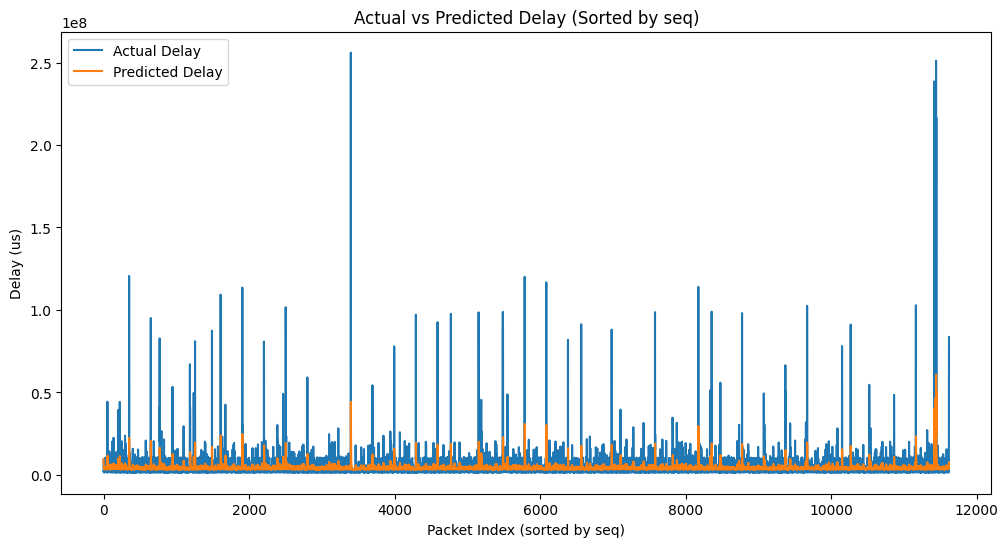

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# delay.txt에서 데이터를 읽어옴
with open("delay.txt", "r") as file:
    lines = file.readlines()

# seq, delay 쌍 추출
data = []
for line in lines:
    match = re.search(r"seq\[(\d+)\],\s*delay\s*=\s*(\d+)", line)
    if match:
        seq = int(match.group(1))
        delay = int(match.group(2))
        data.append((seq, delay))

# DataFrame으로 변환 후 seq 기준 정렬
df = pd.DataFrame(data, columns=["seq", "delay"])
df = df.sort_values(by="seq").reset_index(drop=True)

# 정규화
scaler = MinMaxScaler()
df["delay_scaled"] = scaler.fit_transform(df[["delay"]])

# LSTM 입력 시퀀스 생성 함수
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# 시퀀스 생성
window_size = 10
X, y = create_sequences(df["delay_scaled"].values, window_size)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# LSTM 모델 구축
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
model.fit(X, y, epochs=10, batch_size=32)

# 예측 및 역정규화
predictions = model.predict(X)
predictions_rescaled = scaler.inverse_transform(predictions)

# 실제 값 (정규화 해제)
actual = df["delay"].values[window_size:]

# 성과 측정 (평가 지표 계산: MAE와 RMSE)
mae = mean_absolute_error(actual, predictions_rescaled)
mse = mean_squared_error(actual, predictions_rescaled)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("RMSE:", rmse)

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(actual, label='Actual Delay')
plt.plot(predictions_rescaled, label='Predicted Delay')
plt.legend()
plt.title("Actual vs Predicted Delay (Sorted by seq)")
plt.xlabel("Packet Index (sorted by seq)")
plt.ylabel("Delay (us)")
plt.show()
